In [35]:
import json
import re
import spacy
import tqdm
import logging

# Visualize LDA
import pyLDAvis
import pyLDAvis.sklearn
import pickle 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint

In [2]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)

# Data preparation

In [3]:
df_subset = pd.read_pickle("../data/df_subset.pkl")

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df_subset.Text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        if len(allowed_postags) < 1:
            texts_out.append([token.lemma_ for token in doc])
        else:
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

INFO - 13:37:23: collecting all words and their counts
INFO - 13:37:23: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:37:26: collected 671735 word types from a corpus of 1609166 words (unigram + bigrams) and 937 sentences
INFO - 13:37:26: using 671735 counts as vocab in Phrases<0 vocab, min_count=5, threshold=50, max_vocab_size=40000000>
INFO - 13:37:26: collecting all words and their counts
INFO - 13:37:26: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:37:33: collected 696873 word types from a corpus of 1535548 words (unigram + bigrams) and 937 sentences
INFO - 13:37:33: using 696873 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
INFO - 13:37:33: source_vocab length 671735
INFO - 13:37:38: Phraser built with 3579 phrasegrams
INFO - 13:37:38: source_vocab length 696873
INFO - 13:37:44: Phraser built with 5708 phrasegrams


In [6]:
data_words_nostops = remove_stopwords(data_words)
data_words_trigrams = make_trigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [7]:
documents = [' '.join(doc) for doc in data_lemmatized]

# LDA

In [11]:
no_features = 1000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [12]:
no_topics = 60

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [13]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=15)# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,story,publish,article,video,report,website,site,claim,conservative,allegation,editor,launch,say,organization,accord
Topic 1,tax,fuel,taxis,state,diesel,gasoline,rate,price,federal,road,total,vehicle,revenue,pay,collect
Topic 2,film,die,video,say,ivory,state,politician,short,environmental,award,include,medium,destroy,woman,official
Topic 3,ecovillage,year,specie,publish,history,decline,level,scientific,community,claim,use,climate,focus,sustainable,policy
Topic 4,science,climate,environmental,public,state,global_warme,say,scientific,human,research,climate_change,report,skepticism,scientist,issue
Topic 5,weather,town,television,village,corporate,comment,regard,piece,use,career,graduate,commercial,course,join,news
Topic 6,say,fund,scientist,climate,report,cause,campaign,year,support,state,issue,policy,increase,write,include
Topic 7,say,farage,science,campaign,state,write,public,climate,year,report,make,political,view,cause,policy
Topic 8,party,election,state,candidate,vote,member,conservative,elect,platform,leader,seat,german,policy,european,group
Topic 9,climate,coalition,conference,say,member,science,hold,group,industry,scientific,include,lead,business,scientist,global


In [15]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
story publish article video report website site claim conservative allegation
Topic 1:
tax fuel taxis state diesel gasoline rate price federal road
Topic 2:
film die video say ivory state politician short environmental award
Topic 3:
ecovillage year specie publish history decline level scientific community claim
Topic 4:
science climate environmental public state global_warme say scientific human research
Topic 5:
weather town television village corporate comment regard piece use career
Topic 6:
say fund scientist climate report cause campaign year support state
Topic 7:
say farage science campaign state write public climate year report
Topic 8:
party election state candidate vote member conservative elect platform leader
Topic 9:
climate coalition conference say member science hold group industry scientific
Topic 10:
oil gas spill company report leak study pump water platform
Topic 11:
seed reforestation yield aircraft variety save oil press know crop
Topic 12:
say state time

In [16]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf))
# See model parameters
pprint(lda.get_params())

Log Likelihood:  -2487589.23436367
Perplexity:  682.689102826638
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 60,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [17]:
# Create Document — Topic Matrix
lda_output = lda.transform(tf)
# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]# index names
docnames = ["Doc" + str(i) for i in range(len(documents))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 8), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,Topic50,Topic51,Topic52,Topic53,Topic54,Topic55,Topic56,Topic57,Topic58,Topic59,dominant_topic
Doc0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.999604,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,44
Doc1,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.989966,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,25
Doc2,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.144353,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.450788,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.056849,0.000051,0.000051,0.345139,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,33
Doc3,0.000063,0.072890,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.016040,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.536867,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.336755,0.000063,0.000063,0.033975,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,33
Doc4,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.306279,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.578286,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.091076,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,0.000427,33
Doc5,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.722523,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.166367,0.000087,0.000087,0.000087,0.000087,0.000087,0.106162,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,0.000087,25
Doc6,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.605161,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000

In [18]:
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)# 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
#Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.    0.01  0.    0.    0.    0.    0.    0.    0.01  0.    0.05  0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.14  0.    0.    0.86
   0.    0.13  0.    0.    0.    0.    0.    0.    0.    0.18  0.    0.02
   0.    0.    0.31  0.01  0.    0.05  0.    0.    0.05  0.    0.    0.
   0.    0.    0.02  0.    0.3   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.02  0.    0.02  0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.   -0.38
   0.    0.21  0.    0.   -0.    0.01  0.    0.01  0.    0.82  0.   -0.01
   0.    0.    0.17 -0.    0.    0.14  0.    0.    0.13  0.    0.    0.
   0.    0.    0.03  0.    0.28  0.    0.    0.    0.    0.    0.    0.  ]]
Perc of Variance Explained: 
 [0.11 0.18]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

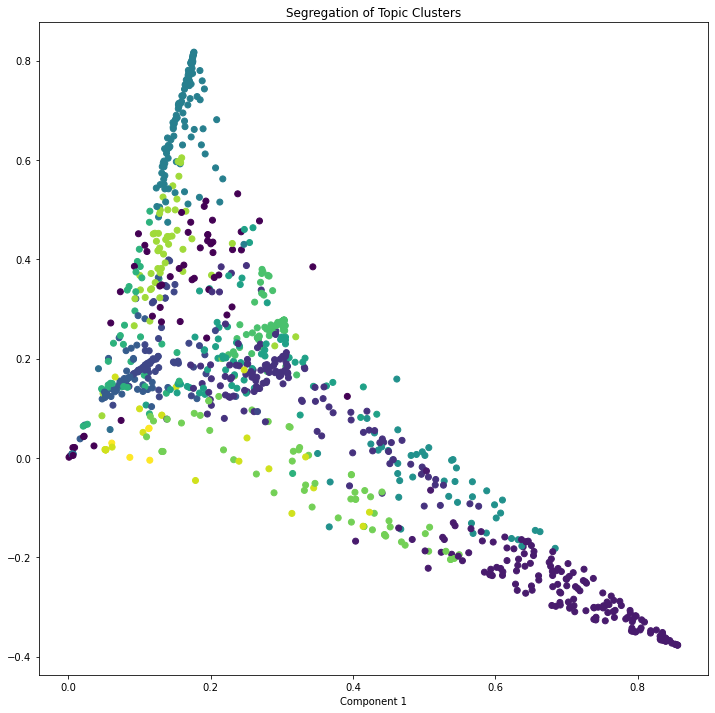

In [19]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [20]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [21]:
sims = cosine_similarity(lda_output, lda_output)

In [30]:
sims[0]

array([1.00000000e+00, 1.78578979e-04, 5.86421802e-01, 5.31767390e-02,
       1.37856683e-01, 1.41748389e-01, 3.09795149e-05, 2.81277062e-01,
       2.19754709e-01, 8.29003430e-01, 2.70787287e-04, 1.11907456e-01,
       2.75213367e-04, 4.55074940e-01, 4.14769116e-01, 3.11386816e-05,
       5.47387538e-05, 5.55365846e-05, 8.33530040e-02, 1.04788045e-04,
       1.44491213e-04, 2.02720792e-05, 1.30226771e-02, 5.12737062e-01,
       1.19619461e-03, 4.09375199e-05, 7.55819311e-01, 1.74993025e-05,
       2.20432923e-04, 6.40175100e-02, 4.72866009e-05, 1.48393108e-03,
       8.83466169e-04, 1.77914197e-05, 6.46142341e-05, 1.55686340e-01,
       2.86282105e-04, 4.78563368e-01, 5.36516864e-05, 1.38836338e-01,
       6.57308981e-05, 8.56316115e-01, 1.03752098e-02, 1.54098896e-04,
       2.55516692e-01, 8.37905265e-05, 1.87232630e-01, 8.78670643e-01,
       1.24301767e-04, 3.27436501e-05, 9.67145218e-04, 1.75953362e-01,
       1.75121222e-04, 2.60345156e-05, 2.17808529e-01, 2.00609172e-01,
      

In [31]:
df_sims = df_subset[['Title', 'Text_processed']].copy()
df_sims['Dominant Topic'] = dominant_topic
df_sims['Sims'] = sims.tolist()

In [33]:
df_sims.head()

,Title,Text_processed,Dominant Topic,Sims
0,Climate change denial,"climate change denial, or global warming denia...",44,"[0.9999999999999997, 0.0001785789789875578, 0...."
1,Khabibullo Abdussamatov,habibullo ismailovich abdussamatov (russian: х...,25,"[0.0001785789789875578, 0.999999999999998, 0.2..."
2,Accuracy in Media,accuracy in media (aim) is an american non-pro...,33,"[0.5864218015617965, 0.24551478646443828, 0.99..."
3,Robert Aderholt,"robert brown aderholt (born july 22, 1965) is ...",33,"[0.05317673896696492, 0.00036760913893750405, ..."
4,Jerry Agar,jerry agar is a conservative talk radio person...,33,"[0.13785668272175575, 0.46374631203846467, 0.8..."


In [34]:
df_sims.to_csv("../data/df_lda_sims.csv")
df_topic_keywords.to_csv("../data/df_lda_topics.csv")